In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

sys.path.append('../../dock/')
sys.path.append('../../ifp/')
sys.path.append('../../mcss/')
sys.path.append('../../score/')
from shared_paths import shared_paths
from containers import Protein
from density_estimate import DensityEstimate

%matplotlib inline

In [2]:
max_proteins = 100
max_ligands = 5
max_poses = 30
proteins = [fname for fname in os.listdir(shared_paths['data']) if fname[0] != '.']

data = {}
for protein in proteins[:max_proteins]:
    print protein
    prot = Protein(protein)
    lm = prot.lm
    ligands = lm.docked(lm.pdb)[:max_ligands+1]
    self_docked = lm.st+'_lig'
    if self_docked in ligands:
        ligands.remove(self_docked)
    else:
        ligands.pop(-1)
    prot.load_docking(ligands, load_fp = True)
    
    data[protein] = {}
    for ligand in ligands:
        data[protein][ligand] = []
        for pose in prot.docking[lm.st].ligands[ligand].poses[:max_poses]:
            data[protein][ligand] += [(pose.gscore, pose.fp, pose.rmsd)]

O60885
GCR
BRAF
DTRANSP
P00749
SMO
P03951
AR
MEK1
5HT2B
P00760
CDK2
SIGMA1
JAK2
ERA
P18031
P00489
A2AR
PLK1
VITD
GLUT1
MGLUR5
STRANSP
B2AR
TRPV1
Q9Y233
P00734
MR
M3
Q16539
P00742
P56817
P07900
P24941
B1AR
CHK1


In [3]:
def overlap(pose1, pose2, codes):
    return sum(np.sqrt(score1*pose2[1][(c, r)])
               for (c, r), score1 in pose1[1].items()
               if c in codes and (c, r) in pose2[1])

def get_norm(poses1, poses2, codes):
    norm = 0
    for pose1 in poses1:
        for pose2 in poses2:
            norm = max(norm, overlap(pose1, pose2, codes))
    return norm

In [159]:
import numpy as np

class DensityEstimate:
    '''
    Computes and stores density estimates f(x) for input values x.

    DensityEstimates are stored in the form of a probability density
    to get a value in the form of counts at a position, just multiply
    by n_samples.

    DensityEstimates can be averaged and two can be combined to get a ratio.

    - Should explore ways to bias the ratio to 1 where there is little data.
    - Could consider collapsing values using dictionary when computing density
      to improve performance when there are many repeated items.
    '''
    def __init__(self, points=100, domain = None, k = 1000,
                 n_samples = 0, out_of_bounds = None):
        '''
        points (int): number of values at which to compute density.
        domain ((float, float)): range of values at which to compute density
            if left as None, use min and max of input data.
        n_samples (int): (Weighted) number of samples used to compute density.
        out_of_bounds (None or float): If asked to return a density for a
            value outside the domain, if None, return closest density, else
            return this value.
        '''
        self.points = points
        self.out_of_bounds = out_of_bounds
        self.k = k
        self.n_samples = n_samples
        if domain is not None:
            self.x = np.linspace(domain[0], domain[1], points)
            self.fx = np.zeros(self.x.shape)
        else:
            self.x = None
            self.fx = None

    # Core methods
    def __call__(self, x):
        '''
        Returns f(x) for the given value of x by linear interpolation.
        If x is out of functions domain, return the closest response
        and print a warning if self.out_of_bounds is None or else
        self.out_of_bounds.
        '''
        if self.x is None: return 0
        if x < self.x[0]:
            print('Warning: value out of domain of function')
            if self.out_of_bounds is None: return self.fx[0]
            return self.out_of_bounds
        if x > self.x[-1]:
            #print('Warning: value out of domain of function')
            if self.out_of_bounds is None: return self.fx[-1]
            return self.out_of_bounds

        idx = 0 # One to right of x
        while x > self.x[idx]: idx += 1

        if not idx: return self.fx[0] # Avoid IndexError

        d = self.x[idx] - self.x[idx-1]
        return (   self.fx[idx-1]  * (self.x[idx] - x)/d
                 + self.fx[idx]    * (x - self.x[idx-1])/d)

    # Combining instances
    def ratio(self, other, prob = True):
        '''
        Returns a new function representing the ratio of self over the other
        function. The domain of the new function covers the domain of both
        input functions with the same number of points as self. If not prob
        , weight ratio by number of samples.

        It would be interesting to evaluate if adding some shrinkage
        prior would give better results!
        '''
        de = DensityEstimate(points = self.points, out_of_bounds=1,
                             n_samples = self.n_samples)
        de.x = np.linspace(min(self.x[0], other.x[0]),
                           max(self.x[-1], other.x[-1]),
                           self.points)
        de.fx = np.array([self(x) / other(x) for x in de.x])
        if not prob: de.fx *= self.n_samples / float(other.n_samples)
        return de

    def uniform(self):
        self.n_samples = 0
        self.fx = np.ones(self.x.shape)
        self.fx /= self.x[-1]-self.x[0]
        return self

    def fit(self, X, weights = 1):
        if self.x is None:
            self.x = np.linspace(X[:, 0].min(), X[:, 0].max(), self.points)

        if not X.shape[0]: return self.uniform()

        self._kde(X, weights)

        #self.fx *= (self.x.shape[0] / (self.x[-1]-self.x[0])) / self.fx.sum()
        #self.n_samples = (weights*np.ones(X.shape)).sum()
        return self
    
    def _kde(self, X, weights):
        '''
        Returns density estimate at each point in self.x for the input data X
        weighted by weights.
        '''
        self.fx = []
        for mean in self.x:
            self.fx += [self._fit_ratio(mean, X, weights)]
        self.fx = np.array(self.fx)
        
    def _fit_point(self, mean, X, weights):
        # Determine width
        width = 0
        while np.sum((X < mean + width)*(mean-width < X)) < self.k:
            width += 0.01
        if width == 0: print mean
        length = min(X.max(), mean+width) - max(X.min(), mean-width)
        return np.sum((X < mean + width)*(mean-width < X)) / length
    
    def _fit_ratio(self, mean, X, weights):
        # Determine width
        width = 0
        while np.sum((X[:, 0] < mean + width)*(mean-width < X[:, 0])) < self.k:
            width += 0.01
        if width == 0: print mean
        print mean, width
        return X[(X[:, 0] < mean + width)*(mean-width < X[:, 0]), 1].mean()
    
    def _gauss(self, mean, sd, x):
        '''
        Return PDF of N(mean, sd**2) at x.
        '''
        return (np.exp(-0.5*((x - mean)/sd)**2)
                / (sd*np.sqrt(2*np.pi)))
    
    def _tri(self, mean, width, x):
        '''
        Return PDF of N(mean, sd**2) at x.
        '''
        kernel =  (3.0/(4.0*width)) * (1-((x-mean)/width)**2)
        kernel[x < mean-width] = 0
        kernel[x > mean+width] = 0
        return kernel
    
    def _uniform(self, mean, width, x):
        '''
        Return PDF of N(mean, sd**2) at x.
        '''
        kernel = np.ones(x.shape)
        kernel[x < mean-width] = 0
        kernel[x > mean+width] = 0
        return kernel
    
    def _fit_ratio(self, mean, X, weights):
        sd = 0.001
        while np.sum(self._tri(mean, sd, X[:, 0])) < self.k:
            sd += 0.001
        kernel = self._tri(mean, sd, X[:, 0])
        return np.sum(X[:, 1]*kernel) / np.sum(kernel)

0.99999711572896133

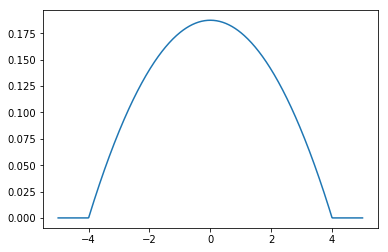

In [160]:
def tri(mean, width, x):
    '''
    Return PDF of N(mean, sd**2) at x.
    '''
    kernel =  (3.0/(4.0*width)) * (1-((x-mean)/width)**2)
    kernel[x < mean-width] = 0
    kernel[x > mean+width] = 0
    return kernel

x = np.linspace(-5, 5, 500)
y = tri(0, 4, x)
plt.plot(x, y)
area = 0
for i in range(x.shape[0]-1):
    area += (x[i+1] - x[i]) * y[i]
area

In [161]:
for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    codes = tuple(codes)
    correct, feature = [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norm = get_norm(poses1, poses2, codes)
                if not norm: continue
                for pose1 in poses1:
                    for pose2 in poses2:
                        correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                        feature += [overlap(pose1, pose2, codes) / norm]
    c = np.vstack([feature, correct]).T
    plt.hist(d[:, 0])
    plt.show()
                     
    ratio =  DensityEstimate(domain = (0, 1), points = 100, k = 100).fit(d)
    plt.plot(ratio.x, ratio.fx)
    plt.show()

    plt.plot(ratio.x, -np.log(ratio.fx))
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'items'

14084


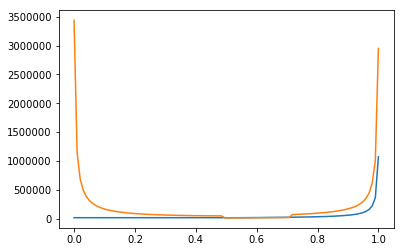

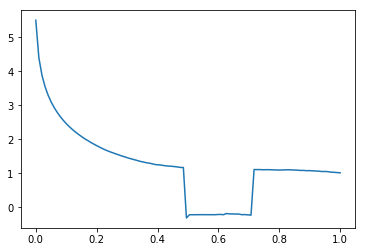

In [106]:

codes = tuple([1])
correct, feature, glide1, glide2 = [], [], [], []
for protein, ligands in data.items():
    for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
        for ligand2, poses2 in ligands.items()[i+1:10]:
            norm = get_norm(poses1, poses2, codes)
            if not norm: continue
            for pose1 in poses1:
                for pose2 in poses2:
                    correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                    glide1 += [pose1[0]]
                    glide2 += [pose2[0]]
                    feature += [overlap(pose1, pose2, codes) / norm]
correct, glide1, glide2, feature = np.array(correct), np.array(glide1), np.array(glide2), np.array(feature)
print np.sum(correct==1)
stats[codes] = {}
stats[codes]['native'] = DensityEstimate(domain = (0, 1), points = 100, k = 10000
                                        ).fit(feature[correct==1])
stats[codes]['reference'] = DensityEstimate(domain = (0, 1), points = 100, k = 10000
                                           ).fit(feature)
plt.plot(stats[codes]['native'].x, stats[codes]['native'].fx)
plt.plot(stats[codes]['reference'].x, stats[codes]['reference'].fx)
plt.show()

stats[codes]['ratio'] = stats[codes]['native'].ratio(stats[codes]['reference'])
plt.plot(stats[codes]['ratio'].x, -np.log(stats[codes]['ratio'].fx))
plt.show()

(1,)


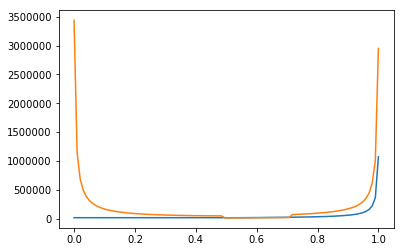

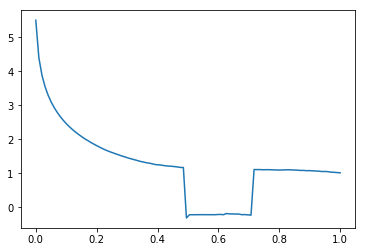

(2,)


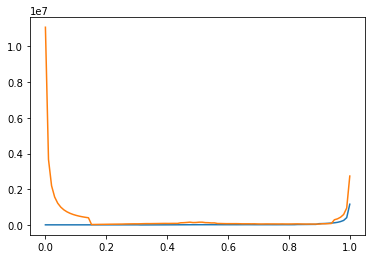

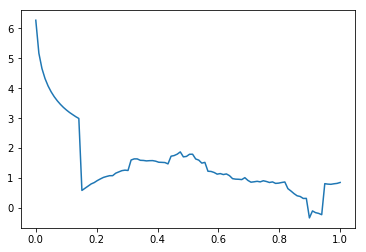

(3,)


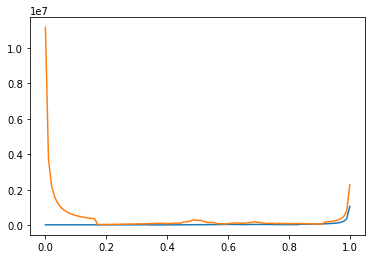

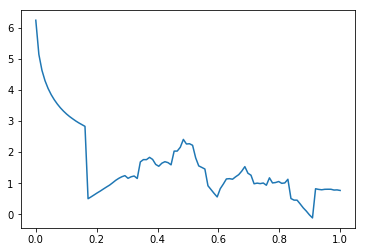

(2, 3)


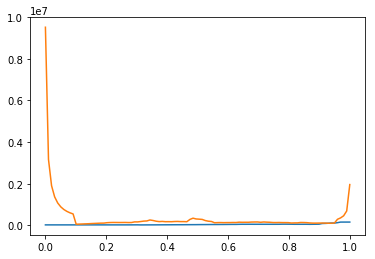

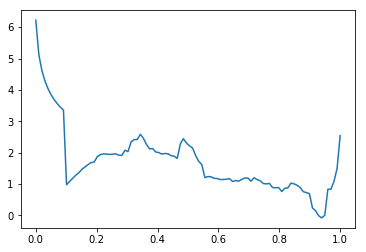

(6,)


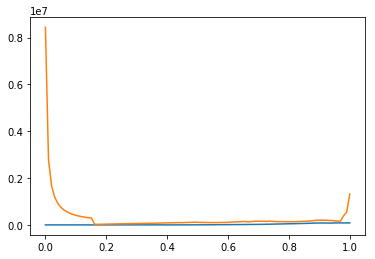

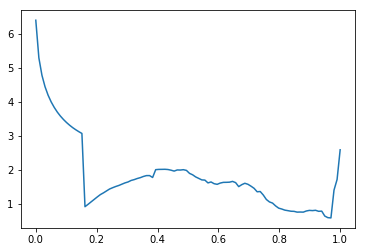

(11,)


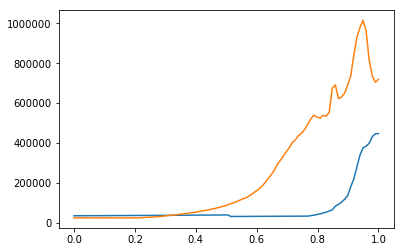

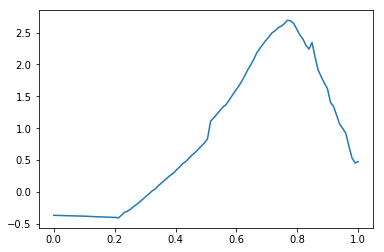

In [107]:
stats = {}
for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    codes = tuple(codes)
    print codes
    correct, feature, glide1, glide2 = [], [], [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norm = get_norm(poses1, poses2, codes)
                if not norm: continue
                for pose1 in poses1:
                    for pose2 in poses2:
                        correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                        glide1 += [pose1[0]]
                        glide2 += [pose2[0]]
                        feature += [overlap(pose1, pose2, codes) / norm]
    correct, glide1, glide2, feature = np.array(correct), np.array(glide1), np.array(glide2), np.array(feature)
    
    stats[codes] = {}
    stats[codes]['native'] = DensityEstimate(domain = (0, 1), points = 100, k = 10000
                                            ).fit(feature[correct==1])
    stats[codes]['reference'] = DensityEstimate(domain = (0, 1), points = 100, k = 10000
                                               ).fit(feature)
    plt.plot(stats[codes]['native'].x, stats[codes]['native'].fx)
    plt.plot(stats[codes]['reference'].x, stats[codes]['reference'].fx)
    plt.show()
    
    stats[codes]['ratio'] = stats[codes]['native'].ratio(stats[codes]['reference'])
    plt.plot(stats[codes]['ratio'].x, -np.log(stats[codes]['ratio'].fx))
    plt.show()

In [36]:
def get_aucs(codes, ratio, w):
    aucs = []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norm = get_norm(poses1, poses2, codes)
                if not norm: continue
                correct, feature, gscores = [], [], []
                for pose1 in poses1:
                    for pose2 in poses2:
                        correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                        feature += [-np.log(ratio(overlap(pose1, pose2, codes)/norm))]
                        gscores += [pose1[0]+pose2[0]]
                correct, feature, gscores = np.array(correct), np.array(feature), np.array(gscores)
                if correct.min() == correct.max(): continue
                aucs += [roc_auc_score(1-correct, w*gscores + feature)]
    return aucs

for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    codes = tuple(codes)
    print codes
    for w in np.linspace(0, 3, 9):
        aucs = get_aucs(codes, stats[codes]['ratio'], w)
        print w, np.mean(aucs)
    aucs = get_aucs(codes, stats[codes]['ratio'], 1000)
    print 1000, np.mean(aucs)
    print

(1,)
0.0 0.711451738416
0.375 0.736134290569
0.75 0.736199201826
1.125 0.733935656472
1.5 0.731027613318
1.875 0.727762439983
2.25 0.724829495688
2.625 0.722095767276
3.0 0.719323474354
1000 0.683692215932

(2,)
0.0 0.658691782252
0.375 0.745726970951
0.75 0.743065070689
1.125 0.736847890854
1.5 0.731010763757
1.875 0.726192952727
2.25 0.722979164478
2.625 0.722251852644
3.0 0.720573222354
1000 0.708773446527

(3,)
0.0 0.59454214929
0.375 0.729680721622
0.75 0.726310716167
1.125 0.721862943337
1.5 0.718574462885
1.875 0.716688658698
2.25 0.7155085346
2.625 0.71451045509
3.0 0.713686586293
1000 0.710847663005

(2, 3)
0.0 0.688421379242
0.375 0.7435794812
0.75 0.731704629167
1.125 0.724642720228
1.5 0.720298452673
1.875 0.71779362314
2.25 0.714848417461
2.625 0.713596239123
3.0 0.711915578323
1000 0.702970766205

(6,)
0.0 0.566211887942
0.375 0.731153381698
0.75 0.729717149582
1.125 0.724375253896
1.5 0.719329367779
1.875 0.715421231862
2.25 0.712437212921
2.625 0.710444764162
3.0 0.7085

In [33]:
# Joint performance

def joint_performance(all_codes, w=1):
    print all_codes
    aucs = []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                correct = []
                for pose1 in poses1:
                        for pose2 in poses2:
                            correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                correct = np.array(correct)
                if correct.min() == correct.max(): continue

                scores = w*np.array([pose1[0] + pose2[0] for pose1 in poses1 for pose2 in poses2])
                for codes in all_codes:
                    codes = tuple(codes)
                    norm = get_norm(poses1, poses2, codes)
                    if not norm: continue
                    score = []
                    for pose1 in poses1:
                        for pose2 in poses2:
                            score += [-np.log(stats[codes]['ratio'](overlap(pose1, pose2, codes)/norm))]
                    scores += np.array(score)  
                aucs += [roc_auc_score(1-correct, scores)]
    plt.hist(aucs)
    plt.show()
    print np.mean(aucs)

[[1], [2], [3], [6], [11]]


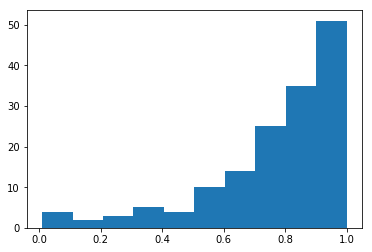

0.767423687459
[[1], [2, 3], [6], [11]]


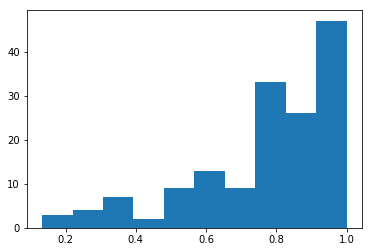

0.76586577172
[[1], [2, 3], [11]]


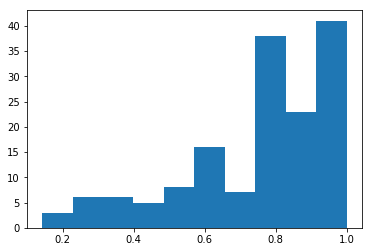

0.750414455364
[[1], [2, 3]]


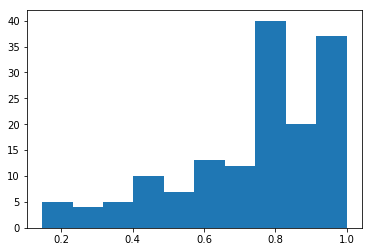

0.736380658319
[[2, 3]]


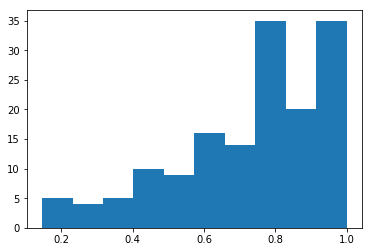

0.725038115505
[[2], [3]]


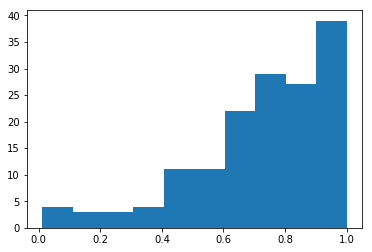

0.728983858
[[]]


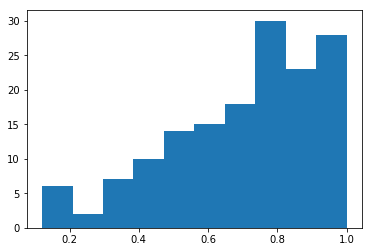

0.701651333384


In [34]:
joint_performance([[1], [2], [3], [6], [11]])
joint_performance([[1], [2, 3], [6], [11]])
joint_performance([[1], [2, 3], [11]])
joint_performance([[1], [2, 3]])
joint_performance([[2, 3]])
joint_performance([[2], [3]])
joint_performance([[]])

0.0
[[1], [2, 3], [6], [11]]


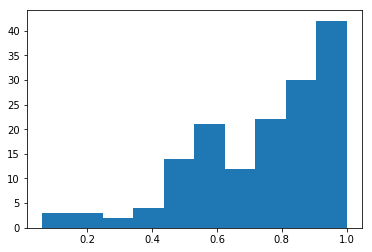

0.737562333723
0.333333333333
[[1], [2, 3], [6], [11]]


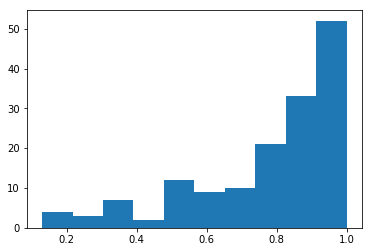

0.777771975851
0.666666666667
[[1], [2, 3], [6], [11]]


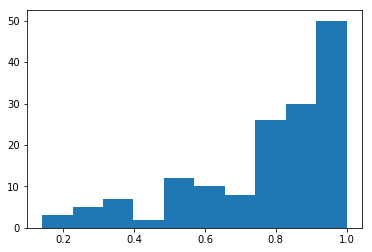

0.772350068399
1.0
[[1], [2, 3], [6], [11]]


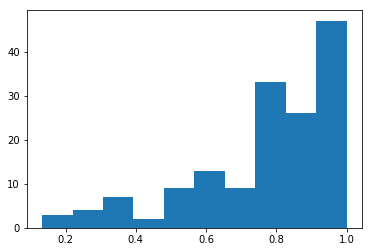

0.76586577172
1.33333333333
[[1], [2, 3], [6], [11]]


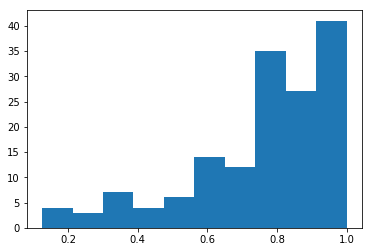

0.759369518535
1.66666666667
[[1], [2, 3], [6], [11]]


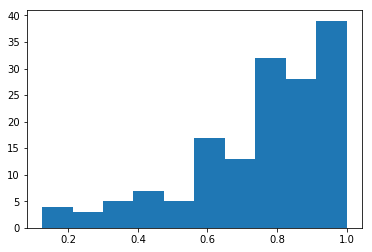

0.753628059127
2.0
[[1], [2, 3], [6], [11]]


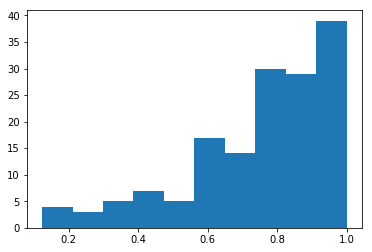

0.749622505318
2.33333333333
[[1], [2, 3], [6], [11]]


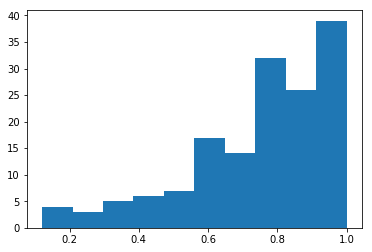

0.746077638995
2.66666666667
[[1], [2, 3], [6], [11]]


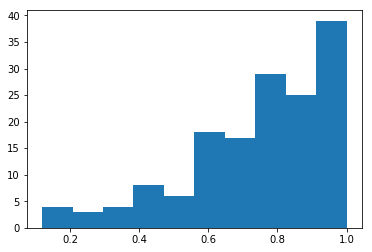

0.742711178008
3.0
[[1], [2, 3], [6], [11]]


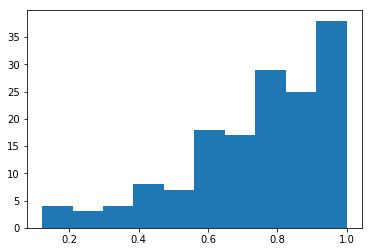

0.740340084053


In [35]:
for w in np.linspace(0, 3, 10):
    print w
    joint_performance([[1], [2, 3], [6], [11]], w)